In [1]:
import mxnet as mx
import os, urllib
import logging
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple
import numpy as np

%matplotlib inline

head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

In [2]:
class WeightedLogisticRegression(mx.operator.CustomOp):
    def __init__(self, neg_w, pos_w):
        self.neg_w = float(neg_w)
        self.pos_w = float(pos_w)
    def forward(self, is_train, req, in_data, out_data, aux):
        x = in_data[0].asnumpy()
        y = np.exp(x - x.max(axis=1).reshape((x.shape[0], 1)))
        y /= y.sum(axis=1).reshape((x.shape[0], 1))
        self.assign(out_data[0], req[0], mx.nd.array(y))
    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        l = in_data[1].asnumpy().ravel().astype(np.int)
        y = out_data[0].asnumpy()
        
        w0 = self.neg_w
        w1 = self.pos_w
        
        # fg wrong
        mask0 = np.ones(y.shape, dtype=float)
        mask0[:,0] = 0.0
        mask0[:,l] = 0.0
        
        # bg wrong
        mask1 = np.ones(y.shape, dtype=float)
        mask1[:,1] = 0.0
        mask1[:,l] = 0.0
        
        # fg right
        mask2 = np.zeros(y.shape, dtype=float)
        mask2[:,l] = 1.0
        mask2[:,0] = 0.0
        
        # bg right
        mask3 = np.zeros(y.shape, dtype=float)
        mask3[:,l] = 1.0
        mask3[:,1] = 0.0
        
        mask = mask0*w0 + mask1*w1 + mask2*w1 + mask3*w0
        
        y[np.arange(l.shape[0]), l] -= 1.0
        y *= mask
        self.assign(in_grad[0], req[0], mx.nd.array(y))

@mx.operator.register("weighted_logistic_regression")
class WeightedLogisticRegressionProp(mx.operator.CustomOpProp):
    def __init__(self, neg_w, pos_w):
        self.neg_w = float(neg_w)
        self.pos_w = float(pos_w)
        super(WeightedLogisticRegressionProp, self).__init__(False)
    def list_arguments(self):
        return ['data', 'label']
    def list_outputs(self):
        return ['output']
    def infer_type(self, in_type):
        dtype = in_type[0]
        return [dtype, dtype], [dtype], []
    def infer_shape(self, in_shape):
        data_shape = in_shape[0]
        label_shape = (in_shape[0][0],)
        output_shape = in_shape[0]
        return [data_shape, label_shape], [output_shape], []
    def create_operator(self, ctx, shapes, dtypes):
        return WeightedLogisticRegression(self.neg_w, self.pos_w)

In [3]:
dshape = [('data', (1,3,224,224))]

sym, arg_params, aux_params = mx.model.load_checkpoint('caffenet-mxnet-jump-start-weighted', 30)
mod = mx.mod.Module(symbol=sym)

# bind the model and set training == False; Define the data shape
mod.bind(for_training=False, data_shapes=dshape)
mod.set_params(arg_params, aux_params)

/home/srip_face/.local/lib/python2.7/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
sym_, arg_params_, aux_params_ = mx.model.load_checkpoint('caffenet-mxnet-jump-start-128', 5)
mod_ = mx.mod.Module(symbol=sym_)

# bind the model and set training == False; Define the data shape
mod_.bind(for_training=False, data_shapes=dshape)
mod_.set_params(arg_params_, aux_params_)

In [10]:
Batch = namedtuple('Batch', ['data'])

def preprocess_image(img, show_img=False):
    '''
    convert the image to a numpy array
    '''
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    return img

# v_dir = '/data3/yingwei/vidDB/diving_share/firstphase/video_first10/LNMISxO35S0_000.mp4'
v_dir = '/data3/yingwei/vidDB/diving_share/firstphase/video_first10/RWNrARSbRCY_040.mp4'
# v_dir = '/data3/yingwei/vidDB/diving_share/firstphase/video_first10/cYkUl8MrXgA_190.mp4'
scores = []
scores_ = []
times = []
cap = cv2.VideoCapture(v_dir)
if cap.isOpened():
    fps = cap.get(5)
    step = int(fps/4.0)
    c = 0
    cap.set(1,0)
    while True:
        ret = cap.grab()
        if not ret:
            break
        if c%step != 0:
            c += 1
            continue
        ret, frame = cap.retrieve()
        if not ret:
            break
        img = preprocess_image(frame)
        mod.forward(Batch([mx.nd.array(img)]))
        mod_.forward(Batch([mx.nd.array(img)]))
        
        # predict
        prob = mod.get_outputs()[0].asnumpy()
        prob_ = mod_.get_outputs()[0].asnumpy()
        scores.append(prob[0][1].copy())
        scores_.append(prob_[0][1].copy())
        times.append(c/fps)
        c += 1

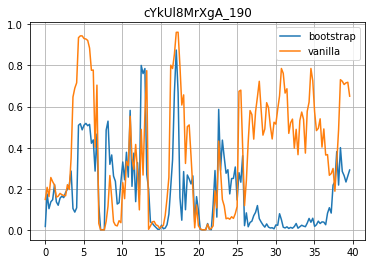

In [6]:
plt.plot(times, scores)
plt.plot(times, scores_)
plt.legend(['bootstrap', 'vanilla'])
plt.grid()
plt.title(v_dir.split('/')[-1].split('.')[0])

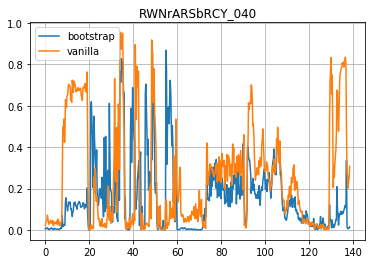

In [11]:
plt.plot(times, scores)
plt.plot(times, scores_)
plt.legend(['bootstrap', 'vanilla'])
plt.grid()
plt.title(v_dir.split('/')[-1].split('.')[0])

In [12]:
cap.set(1,0)
ret,frame = cap.read()
height, width, channels = frame.shape

# Define the codec and create VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'xvid') # Be sure to use lower case
fourcc = cv2.cv.CV_FOURCC(*'xvid')
out = cv2.VideoWriter(v_dir.split('/')[-1].split('.')[0]+'_weighted_30.avi', fourcc, 5.0, (width, height))
# out_ = cv2.VideoWriter(v_dir.split('/')[-1].split('.')[0]+'_10.avi', fourcc, 5.0, (width, height))

In [13]:
for i,itm in enumerate(scores):
    cap.set(1,times[i]*fps)
    ret,frame = cap.read()
    if not ret:
        continue
#     frame_ = frame.copy()
    if itm>0.5:
        cv2.putText(frame, "{0:.2f}".format(itm), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,255),2)
    else:
        cv2.putText(frame, "{0:.2f}".format(itm), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,255),2)
    out.write(frame)
#     if scores_[i]>0.5:
#         cv2.putText(frame_, "{0:.2f}".format(scores_[i]), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,255),2)
#     else:
#         cv2.putText(frame_, "{0:.2f}".format(scores_[i]), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,255),2)
#     out_.write(frame_)

In [14]:
out.release()
# out_.release()